# Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup
Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1638222073388_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.11.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.3.2    
lxml                       4.5.2    
matplotlib                 3.2.1    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.0.3    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  3.0.6    
python-dateutil            2.8.2    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    
t

## Importing
Now, import the installed packages from the previous block below.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data
We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [53]:
df_bus = spark.read.json("s3://sta9760f2021-datasets/yelp_academic_dataset_business.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
Display the number of rows and columns in our dataset.

In [54]:
print(f'Columns: {len(df_bus.dtypes)} | Rows: {(df_bus.count())}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 160585

Display the DataFrame schema below.

In [55]:
df_bus.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `stars`
* `categories`

In [56]:
df_bus.select("business_id", "name", "city", "state", "stars", "categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+--------------------+
|         business_id|                name|       city|state|stars|          categories|
+--------------------+--------------------+-----------+-----+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|  4.0|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|  4.0|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|  4.5|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|  3.0|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|  4.0|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+-----+--------------------+
only showing top 5 rows

## Analyzing Categories
Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [57]:
from pyspark.sql.functions import explode, split

df_bus_cat = df_bus.withColumn('categories',explode(split('categories',", ")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [58]:
df_bus_cat.select("business_id", "categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|  categories|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [59]:
df_bus_cat.select("categories").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1330

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category¶
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [60]:
df_bus_cat.groupby("categories").count().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [61]:
df_bus_cat_bar = df_bus_cat.groupby("categories").count().orderBy('count',ascending=False)
df_bus_cat_bar.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|50763|
|                Food|29469|
|            Shopping|26205|
|       Beauty & Spas|16574|
|       Home Services|16465|
|    Health & Medical|15102|
|      Local Services|12192|
|           Nightlife|11990|
|                Bars|10741|
|          Automotive|10119|
|Event Planning & ...| 9644|
|         Active Life| 9231|
|        Coffee & Tea| 7725|
|          Sandwiches| 7272|
|             Fashion| 6599|
|American (Traditi...| 6541|
|         Hair Salons| 5900|
|               Pizza| 5756|
|     Hotels & Travel| 5703|
|  Breakfast & Brunch| 5505|
+--------------------+-----+
only showing top 20 rows

In [62]:
topd = df_bus_cat_bar.limit(20).toPandas()
topd

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   categories  count
0                 Restaurants  50763
1                        Food  29469
2                    Shopping  26205
3               Beauty & Spas  16574
4               Home Services  16465
5            Health & Medical  15102
6              Local Services  12192
7                   Nightlife  11990
8                        Bars  10741
9                  Automotive  10119
10  Event Planning & Services   9644
11                Active Life   9231
12               Coffee & Tea   7725
13                 Sandwiches   7272
14                    Fashion   6599
15     American (Traditional)   6541
16                Hair Salons   5900
17                      Pizza   5756
18            Hotels & Travel   5703
19         Breakfast & Brunch   5505

In [63]:
plt.figure(figsize=(12,10))
topd.sort_values(by="count").plot(kind="barh", x='categories', figsize=(12,10))
plt.title("Top Categories by Business")
plt.xlabel("count")
plt.ylabel("categories")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'categories')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

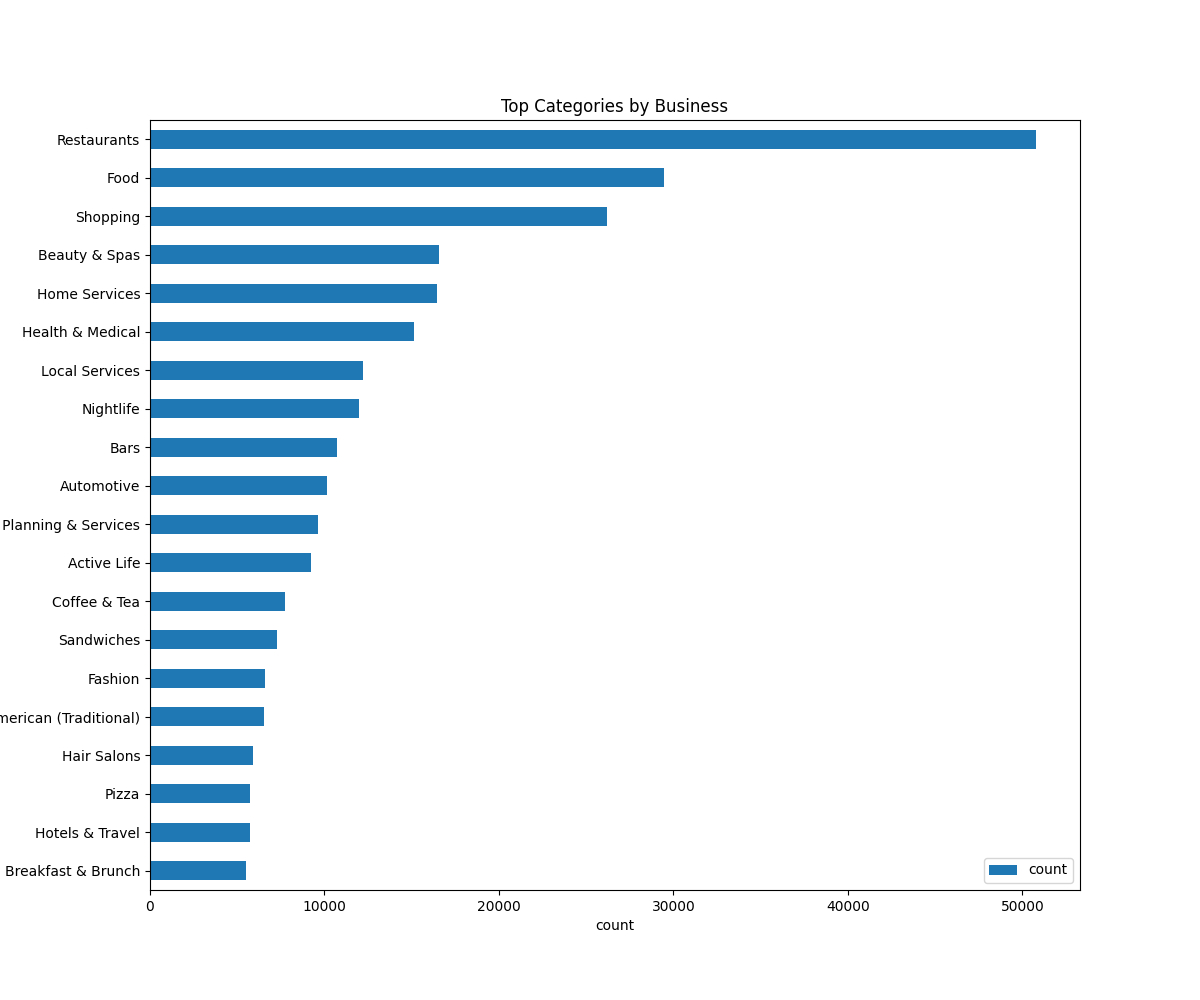

In [64]:
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading Review Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [65]:
df_review = spark.read.json("s3://sta9760f2021-datasets/yelp_academic_dataset_review.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [67]:
df_review.select("business_id", "stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [68]:
df_review_avg = df_review.groupby("business_id").avg("stars")
df_review_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|yHtuNAlYKtRZniO8O...|4.714285714285714|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
|uEUweopM30lHcVxjO...|              3.0|
|L3WCfeVozu5etMhz4...|              4.2|
|XzXcpPCb8Y5huklEN...|4.666666666666667|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [69]:
bus_review = df_review_avg.join(df_bus, df_review_avg.business_id == df_bus.business_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [70]:
bus_review.select("avg(stars)", "stars", "name", "city", "state").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|        avg(stars)|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [71]:
df_skew = bus_review.withColumn("k", (
    (bus_review['avg(stars)'] - bus_review['stars']) / bus_review['stars']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
df_skew_k = df_skew.select("k")
df_skew_k.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                   k|
+--------------------+
|                 0.0|
|0.008547008547008517|
|0.050000000000000044|
|-0.05000000000000...|
|0.030303030303030276|
+--------------------+
only showing top 5 rows

In [73]:
df_skew_k = df_skew_k.toPandas()
df_skew_k.plot(kind='hist',bins=50,density=True, color = 'skyblue', 
               title="Skew between business review and reviewer's rating")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

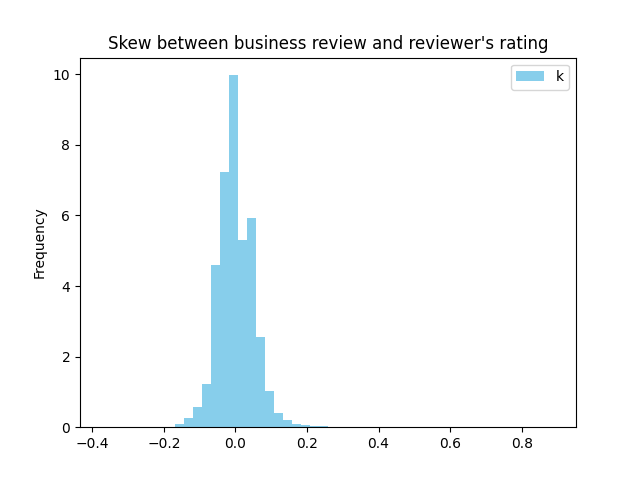

In [74]:
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

Answer: Based on the graph, most of the skew are closed to 0, however, it is slightly postive skew, which mean people who have postive feedback are more likely to leave high star rating. Reviewers who left a written response were more satisfied than normal.

## Which top 5 states have highest reviewers' average star rating in Health & Medical category than others? 

Select neccessary columns "categories", "state", "avg(stars)"

In [75]:
bus_review = df_review_avg.join(df_bus, df_review_avg.business_id == df_bus.business_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
bus_review2 = bus_review.select("categories", "state", "avg(stars)")
bus_review2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-----------------+
|          categories|state|       avg(stars)|
+--------------------+-----+-----------------+
|Burgers, Restaura...|   BC|              3.0|
|Local Services, S...|   MA|4.538461538461538|
|Public Services &...|   TX|              4.2|
|Local Services, D...|   MA|              3.8|
|Nail Salons, Waxi...|   MA|3.606060606060606|
+--------------------+-----+-----------------+
only showing top 5 rows

Split the categories columns

In [77]:
bus_review_split = bus_review2.withColumn('categories', explode(split('categories',", ")))
bus_review_split.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+-----------------+
|   categories|state|       avg(stars)|
+-------------+-----+-----------------+
|      Massage|   TX|4.714285714285714|
|      Barbers|   TX|4.714285714285714|
|Beauty & Spas|   TX|4.714285714285714|
|  Nail Salons|   MA|3.606060606060606|
|       Waxing|   MA|3.606060606060606|
+-------------+-----+-----------------+
only showing top 5 rows

Only pick category of Health & Medical by using `filter`

In [78]:
bus_state_review_hm = bus_review_split.filter(bus_review_split.categories == "Health & Medical")
bus_state_review_hm.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+-----------------+
|      categories|state|       avg(stars)|
+----------------+-----+-----------------+
|Health & Medical|   TX|4.333333333333333|
|Health & Medical|   GA|3.909090909090909|
|Health & Medical|   FL|4.428571428571429|
|Health & Medical|   OR|              5.0|
|Health & Medical|   OR|4.453333333333333|
+----------------+-----+-----------------+
only showing top 5 rows

Number of columns and rows

In [79]:
print(f'Columns: {len(bus_state_review_hm.dtypes)} | Rows: {(bus_state_review_hm.count())}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 3 | Rows: 15102

Show top 5 states with the highest reviewers' rating in Health & Medical category

In [80]:
bus_state_review_hm1 = bus_state_review_hm.groupby("state").avg("avg(stars)").orderBy(
    "avg(avg(stars))", ascending=False)
bus_state_review_hm1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|state|   avg(avg(stars))|
+-----+------------------+
|   DC|               5.0|
|   CA| 4.384615384615385|
|   OR| 4.079730799151105|
|   TX| 4.055223322800128|
|   CO|3.9583030934710655|
+-----+------------------+
only showing top 5 rows

In [81]:
plt.figure()
bus_state_review_hm1.limit(5).toPandas().sort_values(by="avg(avg(stars))").plot(kind="barh", x='state')
plt.title("Top 5 states with highest reviewers' star rating in Health & Medical category")
plt.xlabel("rating")
plt.ylabel("state")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'state')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

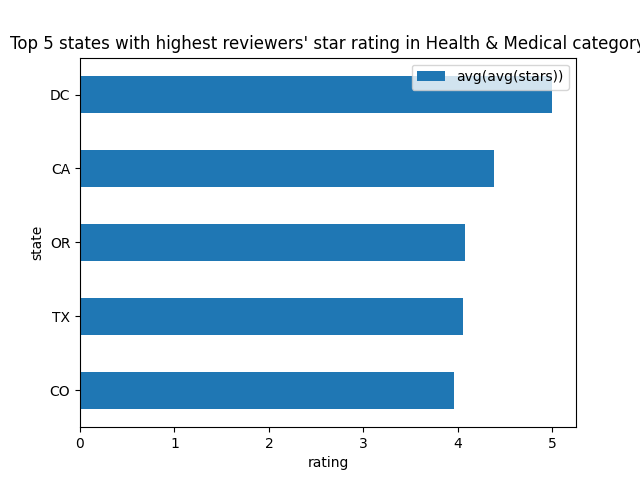

In [82]:
%matplot plt

Based on the graph, DC is the state that has the highest star rating in Health & Medical category, CA is the second, the rest of states are OR, TX, and CO.

# Should the Elite be Trusted? (Or, some other analysis of your choice)
For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

## Loading data

In [83]:
df_user = spark.read.json("s3://sta9760f2021-datasets/yelp_academic_dataset_user.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

### Data cleaning

In [85]:
df_user_clean = df_user.withColumnRenamed("average_stars", "user_stars")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
df_user_clean1 = df_user_clean.select("user_id", "elite", "user_stars", "review_count")
df_user_clean1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+------------+
|             user_id|               elite|user_stars|review_count|
+--------------------+--------------------+----------+------------+
|q_QQ5kBBwlCcbL1s4...|2006,2007,2008,20...|      3.85|        1220|
|dIIKEfOgo0KqUfGQv...|2007,2008,2009,20...|      4.09|        2136|
|D6ErcUnFALnCQN4b1...|           2010,2011|      3.76|         119|
|JnPIjvC0cmooNDfsa...|2009,2010,2011,20...|      3.77|         987|
|37Hc8hr3cw0iHLoPz...|      2009,2010,2011|      3.72|         495|
+--------------------+--------------------+----------+------------+
only showing top 5 rows

Create a dataset "df_user_elite" only with elite users

In [87]:
df_user_elite = df_user_clean1.filter(df_user_clean1.elite != "")
df_user_elite.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+------------+
|             user_id|               elite|user_stars|review_count|
+--------------------+--------------------+----------+------------+
|q_QQ5kBBwlCcbL1s4...|2006,2007,2008,20...|      3.85|        1220|
|dIIKEfOgo0KqUfGQv...|2007,2008,2009,20...|      4.09|        2136|
|D6ErcUnFALnCQN4b1...|           2010,2011|      3.76|         119|
|JnPIjvC0cmooNDfsa...|2009,2010,2011,20...|      3.77|         987|
|37Hc8hr3cw0iHLoPz...|      2009,2010,2011|      3.72|         495|
+--------------------+--------------------+----------+------------+
only showing top 5 rows

### Join datasets

Combine business dataset and review dataset with user dataset (df_user_elite)

In this part, I join the datasets to find the star rating of the elite users only that gave to the business

In [88]:
df_bus = spark.read.json("s3://sta9760f2021-datasets/yelp_academic_dataset_business.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
df_review = spark.read.json("s3://sta9760f2021-datasets/yelp_academic_dataset_review.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
df_rev_clean = df_review.withColumnRenamed("stars", "user_bus_stars")
df_rev_clean1 = df_rev_clean.select("user_id", "business_id", "user_bus_stars")
elite_review = df_rev_clean1.join(df_user_elite, 
                                  df_rev_clean1.user_id == df_user_elite.user_id)
elite_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------+--------------------+--------------------+----------+------------+
|             user_id|         business_id|user_bus_stars|             user_id|               elite|user_stars|review_count|
+--------------------+--------------------+--------------+--------------------+--------------------+----------+------------+
|0JQYSCWOQWKqK7KMj...|eCLuYcTuQpDPFOezh...|           4.0|0JQYSCWOQWKqK7KMj...| 2015,2016,2017,2018|      3.83|         232|
|l91pXxTZGS5CNWjNB...|RP_U_TyolABy3eYuR...|           3.0|l91pXxTZGS5CNWjNB...|2012,2013,2014,20...|      3.53|         424|
|WAyYDJKFMzlTTnKxq...|_6TF9YiOiYSToPBRz...|           5.0|WAyYDJKFMzlTTnKxq...|2011,2012,2013,20...|      3.65|         236|
|g34Qcj06LmCDhKzks...|bxy3khT-2R66tcdKj...|           4.0|g34Qcj06LmCDhKzks...|2017,2018,2019,20,20|      3.99|         289|
|_UMIAnpnXWAqXS4y6...|A0F6H8OO3qYAvI2L3...|           4.0|_UMIAnpnXWAqXS4y6...|2015,2016,2017,20...|      4.37|         195|


Combine business dataset with elite_review

In this part, I join the business dataset with actual business rating to the elite review dataset, and then I can use "(elite users rating gave to the business - actual business rating) / actual business rating" to see the differnece between elite users gave to the business and the actual business rating

In [91]:
df_bus_clean = df_bus.withColumnRenamed("stars", "bus_act_stars")
df_bus_clean1 = df_bus_clean.select("business_id", "bus_act_stars")
elite_review_bus = df_bus_clean1.join(elite_review, df_bus_clean1.business_id == elite_review.business_id)
elite_review_bus.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+--------------------+--------------------+--------------+--------------------+--------------------+----------+------------+
|         business_id|bus_act_stars|             user_id|         business_id|user_bus_stars|             user_id|               elite|user_stars|review_count|
+--------------------+-------------+--------------------+--------------------+--------------+--------------------+--------------------+----------+------------+
|eCLuYcTuQpDPFOezh...|          4.0|0JQYSCWOQWKqK7KMj...|eCLuYcTuQpDPFOezh...|           4.0|0JQYSCWOQWKqK7KMj...| 2015,2016,2017,2018|      3.83|         232|
|RP_U_TyolABy3eYuR...|          3.0|l91pXxTZGS5CNWjNB...|RP_U_TyolABy3eYuR...|           3.0|l91pXxTZGS5CNWjNB...|2012,2013,2014,20...|      3.53|         424|
|_6TF9YiOiYSToPBRz...|          3.5|WAyYDJKFMzlTTnKxq...|_6TF9YiOiYSToPBRz...|           5.0|WAyYDJKFMzlTTnKxq...|2011,2012,2013,20...|      3.65|         236|
|bxy3khT-2R66tcdKj...|          4.0|g34Q

In [96]:
elite_skew = elite_review_bus.withColumn("k", (
    (elite_review_bus['user_bus_stars'] - elite_review_bus['bus_act_stars']) 
    / elite_review_bus['bus_act_stars']))
elite_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+--------------------+--------------------+--------------+--------------------+--------------------+----------+------------+-------------------+
|         business_id|bus_act_stars|             user_id|         business_id|user_bus_stars|             user_id|               elite|user_stars|review_count|                  k|
+--------------------+-------------+--------------------+--------------------+--------------+--------------------+--------------------+----------+------------+-------------------+
|eCLuYcTuQpDPFOezh...|          4.0|0JQYSCWOQWKqK7KMj...|eCLuYcTuQpDPFOezh...|           4.0|0JQYSCWOQWKqK7KMj...| 2015,2016,2017,2018|      3.83|         232|                0.0|
|RP_U_TyolABy3eYuR...|          3.0|l91pXxTZGS5CNWjNB...|RP_U_TyolABy3eYuR...|           3.0|l91pXxTZGS5CNWjNB...|2012,2013,2014,20...|      3.53|         424|                0.0|
|_6TF9YiOiYSToPBRz...|          3.5|WAyYDJKFMzlTTnKxq...|_6TF9YiOiYSToPBRz...|           5.0|WAyYDJK

In [97]:
elite_skew_k = elite_skew.select("k")
elite_skew_k.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|                  k|
+-------------------+
|                0.0|
|                0.0|
|0.42857142857142855|
|                0.0|
|                0.0|
+-------------------+
only showing top 5 rows

In [98]:
elite_skew_k = elite_skew_k.toPandas()
elite_skew_k.plot(kind='hist',bins=50,density=True, color = 'skyblue')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

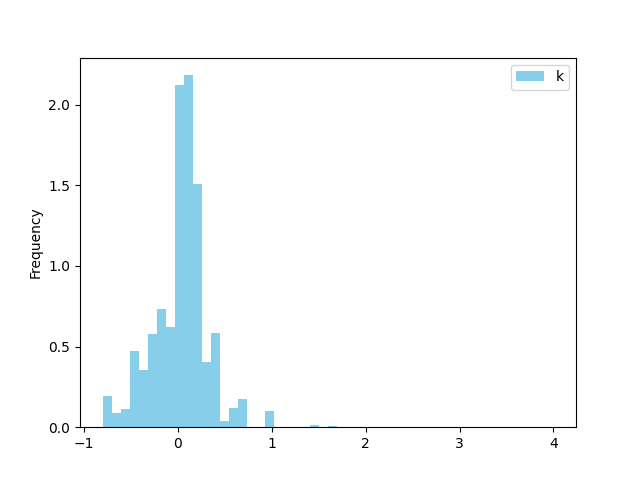

In [99]:
%matplot plt

Based on the graph, most of the k are closed to 0 and distributed between 0 and 1, and it is negative skew, which means most of elite usesrs would give the similar or a little bit higher rating than the actual rating for the business. And there are some outliers shows that some elite users would give much higher rating than the actual business rating.